In [10]:
# naively implementing CNOT on dual-rail
from qutip import tensor, basis, Qobj
import numpy as np
from quantum_logical.basis import DualRail
from quantum_logical.unitary_util import ImplicitUnitaryGate
from qiskit.circuit.library import HGate, CXGate, iSwapGate
from qiskit import QuantumCircuit
from weylchamber import c1c2c3
from qiskit.quantum_info import Operator
from qiskit import transpile

Load the dualrail encoding and convert HGate and CNOT gate into logical gates


In [11]:
encoding = DualRail()
op = encoding.logical_basis.transform_operator.full()

In [12]:
# U = |01><0| + |10><1|
print(op)

[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]


In [13]:
# for 2 qubits
# U = |0101><00| + |0110><01| + |1001><10| + |1010><11|
print(np.kron(op, op))

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [14]:
# A' = U @ A @ U^dag
new_op = op @ HGate().to_matrix() @ op.conj().T
logical_h = ImplicitUnitaryGate(new_op)

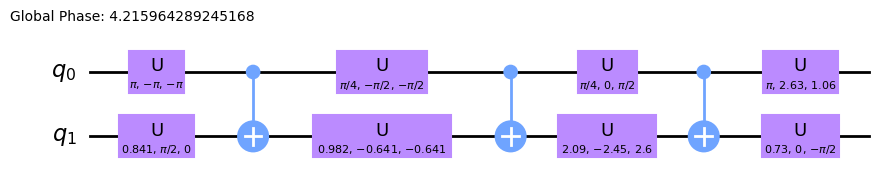

In [15]:
qc = QuantumCircuit(2)
qc.append(ImplicitUnitaryGate(logical_h), [0, 1])
qc.decompose().draw("mpl")

In [16]:
# note logical H is a physical ECP gate
c1c2c3(ImplicitUnitaryGate(new_op).to_matrix())

(0.5, 0.25, 0.25)

In [17]:
# A' = U @ A @ U^dag
new_op = np.kron(op, op) @ CXGate().to_matrix() @ np.kron(op, op).conj().T
logical_cnot = ImplicitUnitaryGate(new_op)
print(np.real(logical_cnot.to_matrix()))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


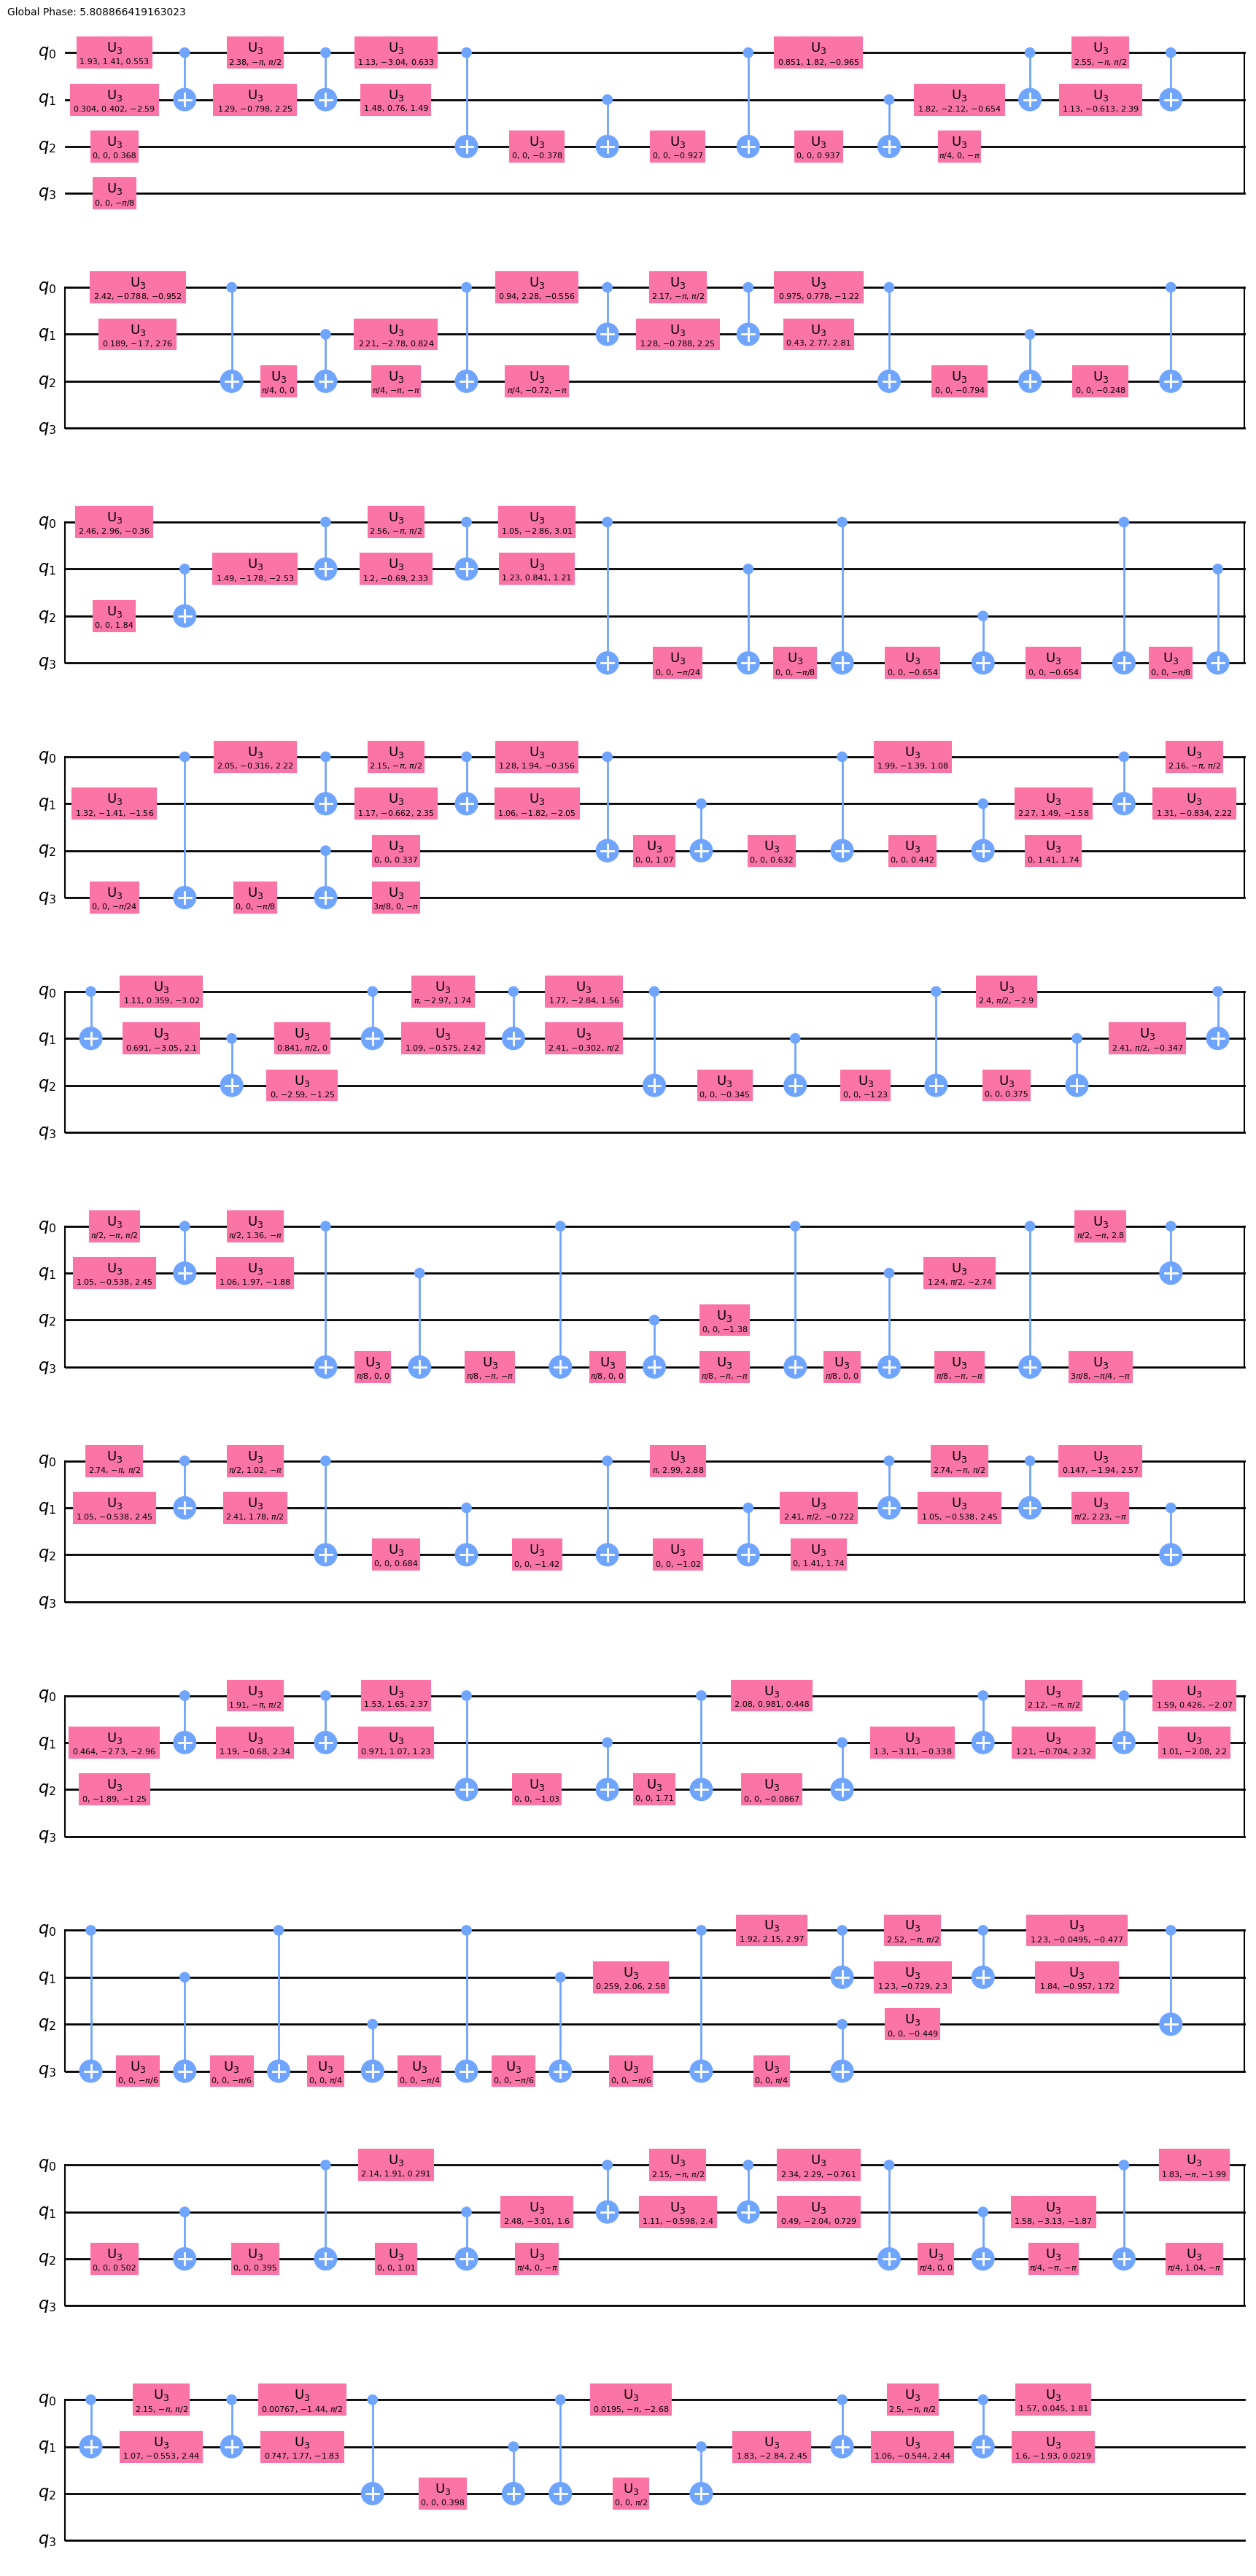

In [18]:
# look at how expensive the overhead is !!!
qc = QuantumCircuit(4)
qc.append(logical_cnot, [0, 1, 2, 3])
qc.decompose().draw("mpl")
optimized = transpile(qc, basis_gates=["cx", "u3"], optimization_level=3)
optimized.draw("mpl")

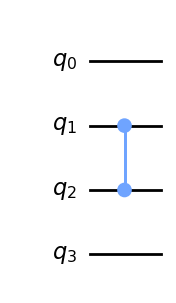

In [19]:
# clearly this is a bad idea
# we should instead do a cheaper operator on the basis, then determine what logical operator it is
# trying to build a CNOT in dual-rail is so expensive since not naturally suited for it
# so explore building gate other direction, start from the encoding and build a gate

qc = QuantumCircuit(4)
qc.cz(1, 2)
display(qc.draw("mpl"))

# what does this gate do on the encoding?
cz_op = Operator(qc).data

In [20]:
# A = U^dag @ A' @ U
new_op = np.kron(op, op).conj().T @ cz_op @ np.kron(op, op)
logical_cnot = ImplicitUnitaryGate(new_op)
print(np.real(logical_cnot.to_matrix()))

# looks like we built a much cheaper CNOT :)
print(c1c2c3(logical_cnot.to_matrix()))

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
(0.5, 0.0, 0.0)


What if we did a different physical gate?


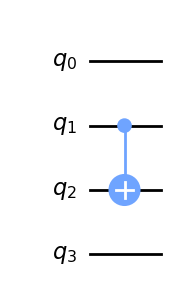

(0.0, 0.0, 0.0)


In [21]:
# if we use a CX, we get an identity
# interesting, that local unitaries are non-local on the encoding

qc = QuantumCircuit(4)
qc.append(CXGate(), [1, 2])

# what does this gate do on the encoding?
exp_op = Operator(qc).data
# A = U^dag @ A' @ U
new_op = np.kron(op, op).conj().T @ exp_op @ np.kron(op, op)
logical_cnot = ImplicitUnitaryGate(new_op)

display(qc.draw("mpl"))
print(c1c2c3(logical_cnot.to_matrix()))

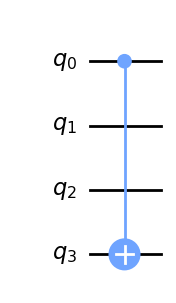

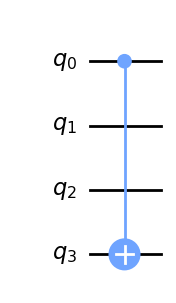

(0.0, 0.0, 0.0)


In [27]:
# but doesn't easily generalzie to other physical gates
qc = QuantumCircuit(4)
# qc.append(iSwapGate().power(1 / 2), [1, 2])
qc.cx(0, 3)
display(qc.draw("mpl"))

# what does this gate do on the encoding?
exp_op = Operator(qc).data
# A = U^dag @ A' @ U
new_op = np.kron(op, op).conj().T @ exp_op @ np.kron(op, op)
logical_cnot = ImplicitUnitaryGate(new_op)

display(qc.draw("mpl"))
print(c1c2c3(logical_cnot.to_matrix()))

- what does it means that the resulting gate is not unitary?

- either we are messing something up with our implicit unitary gate

  - i.e. we need to find some other solution to the don't care terms to enforce unitarity

- or this operator just can't be projected into the 2Q subspace
  - so what is it doing then? its doing a non-unitary 2Q gate...?
  - or something else, I'm not sure right
